In [2]:
import torch
import torch.nn as nn
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from torch.autograd.function import Function
import numpy as np
import torch.utils.data as Data
import math
from torch.utils.data import DataLoader
import torch.optim as optim
import copy
import time
from torch.optim import Adam
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTE
from torch.cuda.amp import autocast as autocast
from torch.cuda.amp import GradScaler
import matplotlib.pyplot as plt

from torch import randperm
from sklearn.utils import resample
import numpy as np
from sklearn.model_selection import train_test_split

import argparse

In [3]:
# train_x_list = "C:/Users/Savior/Desktop/wisdm/wisdm/x_train.npy"
# train_y_list = "C:/Users/Savior/Desktop/wisdm/wisdm/y_train.npy"
# test_x_list = "C:/Users/Savior/Desktop/wisdm/wisdm/x_test.npy"
# test_y_list = "C:/Users/Savior/Desktop/wisdm/wisdm/y_test.npy"

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
parser = argparse.ArgumentParser()
parser.add_argument('-f', type=str, default="读取额外的参数")
parser.add_argument('--bs', type=int, default=256, help='Batch size')
parser.add_argument('--float', type=int, default=5e-4, help='Learning rate')
parser.add_argument('--epoch', type=int, default=200, help='Epoch')
args = parser.parse_args(args=[])

#load data
train_x = torch.from_numpy(np.load('/root/HAR/dataset/UCI HAR Dataset/train/x_train.npy')).float()
train_y = torch.from_numpy(np.load('/root/HAR/dataset/UCI HAR Dataset/train/y_train.npy')).long()-1
train_y = train_y.squeeze(1)


train_x0, test_x, train_y0, test_y = train_test_split(train_x, train_y, test_size=0.1)
train_data, val_data, train_label, val_label = train_test_split(train_x0, train_y0, test_size=0.15)

train_dataset = Data.TensorDataset(train_data, train_label)
val_dataset = Data.TensorDataset(val_data, val_label)
test_dataset = Data.TensorDataset(test_x, test_y)

# train_loader = Data.DataLoader(dataset=train_dataset, batch_size=args.bs, shuffle=True)
# test_loader = Data.DataLoader(dataset=test_dataset, batch_size=args.bs, shuffle=True)
# val_loader = Data.DataLoader(dataset=val_dataset, batch_size=args.bs, shuffle=True)

In [4]:
# #数据上采样部分
#
# data_train= HAR_BorderlineSMOTE(train_x_list, train_y_list)
# train_dataset,val_dataset = data_train.HAR_data()
# data_test = HAR(test_x_list, test_y_list)
# test_dataset = data_test.HAR_data()

In [5]:
data_loader = Data.DataLoader(dataset=train_dataset, batch_size=2048, shuffle=True)
for data, label in data_loader:
    print(data.size())  # 输出第一个样本的大小
    break

torch.Size([2048, 128, 9])


In [6]:
class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim, size_average=True):
        super(CenterLoss, self).__init__()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))
        self.centerlossfunc = CenterlossFunc.apply
        self.feat_dim = feat_dim
        self.size_average = size_average

    def forward(self, label, feat):
        batch_size = feat.size(0)
        feat = feat.view(batch_size, -1)
        # To check the dim of centers and features
        if feat.size(1) != self.feat_dim:
            raise ValueError("Center's dim: {0} should be equal to input feature's \
                            dim: {1}".format(self.feat_dim,feat.size(1)))
        batch_size_tensor = feat.new_empty(1).fill_(batch_size if self.size_average else 1)
        loss = self.centerlossfunc(feat, label, self.centers, batch_size_tensor)
        return loss


class CenterlossFunc(Function):
    @staticmethod
    def forward(ctx, feature, label, centers, batch_size):
        ctx.save_for_backward(feature, label, centers, batch_size)
        centers_batch = centers.index_select(0, label.long())
        return (feature - centers_batch).pow(2).sum() / 2.0 / batch_size

    @staticmethod
    def backward(ctx, grad_output):
        feature, label, centers, batch_size = ctx.saved_tensors
        centers_batch = centers.index_select(0, label.long())
        diff = centers_batch - feature
        # init every iteration
        counts = centers.new_ones(centers.size(0))
        ones = centers.new_ones(label.size(0))
        grad_centers = centers.new_zeros(centers.size())

        counts = counts.scatter_add_(0, label.long(), ones)
        grad_centers.scatter_add_(0, label.unsqueeze(1).expand(feature.size()).long(), diff)
        grad_centers = grad_centers/counts.view(-1, 1)
        return - grad_output * diff / batch_size, None, grad_centers / batch_size, None

In [7]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print("使用GPU训练中：{}".format(torch.cuda.get_device_name()))
else:
    device = torch.device("cpu")
    print("使用CPU训练")

使用GPU训练中：NVIDIA GeForce RTX 4090


In [8]:
def conv3(in_planes, out_planes, stride=1, groups=1):
    """3x3 convolution with padding"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, groups=groups, bias=False)


def conv1(in_planes, out_planes, stride=1):
    """1x1 convolution"""

    return nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class SEModule(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Conv1d(channels, channels // reduction, kernel_size=1, padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv1d(channels // reduction, channels, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        x = self.avg_pool(input)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return input * x

class EfficientChannelAttention(nn.Module):           # Efficient Channel Attention module
    def __init__(self, c, b=1, gamma=2):
        super(EfficientChannelAttention, self).__init__()
        t = int(abs((math.log(c, 2) + b) / gamma))
        k = t if t % 2 else t + 1
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.conv1 = nn.Conv1d(1, 1, kernel_size=k, padding=int(k/2), bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.avg_pool(x)
        x = self.conv1(x.transpose(-1, -2)).transpose(-1, -2)
        out = self.sigmoid(x)
        return out

class GatedRes2NetBottleneck1(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, downsample=None,
                 stride=1, scales=4, groups=1, mod='ECA', norm_layer=None):
        super(GatedRes2NetBottleneck1, self).__init__()
        if planes * groups % scales != 0:
            raise ValueError('Planes must be divisible by scales')
        if norm_layer is None:
            norm_layer = nn.BatchNorm1d
        bottleneck_planes = groups * planes
        self.conv1 = conv1(inplanes, bottleneck_planes, stride)
        self.bn1 = norm_layer(bottleneck_planes)
        self.conv2 = nn.ModuleList([conv3(bottleneck_planes // scales,
                                          bottleneck_planes // scales,
                                          groups=groups) for _ in range(scales - 1)])
        self.bn2 = nn.ModuleList([norm_layer(bottleneck_planes // scales)
                                  for _ in range(scales - 1)])
        self.judge = nn.ModuleList([conv1(bottleneck_planes+2*bottleneck_planes // scales,
                                          bottleneck_planes // scales
                                          ) for _ in range(scales - 2)])
        self.tanh = nn.Tanh()


        self.conv3 = conv1(bottleneck_planes, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.model=mod
        if mod == 'ECA':
            self.mod = EfficientChannelAttention(self.expansion*planes)
        elif mod == 'SE':
            self.mod = SEModule(self.expansion*planes)

        self.downsample = downsample
        self.stride = stride
        self.scales = scales

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        xs = torch.chunk(out, self.scales, 1)
        ys = []

        #GATE1
        for s in range(self.scales):
            if s == 0:
                ys.append(xs[s])
            elif s == 1:
            # else:
                ys.append(self.relu(self.bn2[s - 1](self.conv2[s - 1](xs[s]))))
            else:
                gate = self.tanh(self.judge[s - 2](torch.cat([out,xs[s],ys[-1]],dim=1)))
                ys.append(self.relu(self.bn2[s - 1](self.conv2[s - 1](xs[s] + gate * ys[-1]))))

        # #NO-GATE
        # for s in range(self.scales):
        #     if s == 0:
        #         ys.append(xs[s])
        #     # elif s == 1:
        #     else:
        #         ys.append(self.relu(self.bn2[s - 1](self.conv2[s - 1](xs[s]))))
        #     # else:
        #     #     gate = self.tanh(self.judge[s - 2](torch.cat([out,xs[s],ys[-1]],dim=1)))
        #     #     ys.append(self.relu(self.bn2[s - 1](self.conv2[s - 1](xs[s] + gate * ys[-1]))))


        out = torch.cat(ys, 1)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.model =='SE':
            out = self.mod(out)
        elif self.model == 'ECA':
            x = self.mod(out)
            out= out+x

        if self.downsample is not None:
            identity = self.downsample(identity)

        out = out + identity
        out = self.relu(out)

        return out
    
class GatedRes2NetBottleneck2(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, downsample=None,
                 stride=1, scales=4, groups=1, mod='ECA', norm_layer=None):
        super(GatedRes2NetBottleneck2, self).__init__()
        if planes * groups % scales != 0:
            raise ValueError('Planes must be divisible by scales')
        if norm_layer is None:
            norm_layer = nn.BatchNorm1d
        bottleneck_planes = groups * planes
        self.conv1 = conv1(inplanes, bottleneck_planes, stride)
        self.bn1 = norm_layer(bottleneck_planes)
        self.conv2 = nn.ModuleList([conv3(bottleneck_planes // scales,
                                          bottleneck_planes // scales,
                                          groups=groups) for _ in range(scales - 1)])
        self.bn2 = nn.ModuleList([norm_layer(bottleneck_planes // scales)
                                  for _ in range(scales - 1)])
        self.judge = nn.ModuleList([conv1(bottleneck_planes+2*bottleneck_planes // scales,
                                          bottleneck_planes // scales
                                          ) for _ in range(scales - 2)])
        self.tanh = nn.Tanh()


        self.conv3 = conv1(bottleneck_planes, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.model=mod
        if mod == 'ECA':
            self.mod = EfficientChannelAttention(self.expansion*planes)
        elif mod == 'SE':
            self.mod = SEModule(self.expansion*planes)

        self.downsample = downsample
        self.stride = stride
        self.scales = scales

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        xs = torch.chunk(out, self.scales, 1)
        ys = []

        #GATE1
        for s in range(self.scales):
            if s == 0:
                ys.append(xs[s])
            elif s == 1:
            # else:
                ys.append(self.relu(self.bn2[s - 1](self.conv2[s - 1](xs[s]))))
            else:
                gate = self.tanh(self.judge[s - 2](torch.cat([out,xs[s],ys[-1]],dim=1)))
                ys.append(self.relu(self.bn2[s - 1](self.conv2[s - 1](xs[s] + gate * ys[-1]))))

        #NO-GATE
        # for s in range(self.scales):
        #     if s == 0:
        #         ys.append(xs[s])
        #     # elif s == 1:
        #     else:
        #         ys.append(self.relu(self.bn2[s - 1](self.conv2[s - 1](xs[s]))))
        #     # else:
        #     #     gate = self.tanh(self.judge[s - 2](torch.cat([out,xs[s],ys[-1]],dim=1)))
        #     #     ys.append(self.relu(self.bn2[s - 1](self.conv2[s - 1](xs[s] + gate * ys[-1]))))


        out = torch.cat(ys, 1)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.model =='SE':
            out = self.mod(out)
        elif self.model == 'ECA':
            x = self.mod(out)
            out= out+x

        if self.downsample is not None:
            identity = self.downsample(identity)

        out = out + identity
        out = self.relu(out)

        return out

class GatedFCN2(nn.Module):
    def __init__(self, layers, maxlength=18, groups=1,
                  width=8,scales=4,mod='ECA', norm_layer=None,inplanes=128):
        super(GatedFCN2, self).__init__()
        planes = [int(width * scales * 2 ** i) for i in range(4)]
        #planes=torch.tensor(planes)
        #planes=planes.to('cuda')
        self.pre=inplanes
        self.inplanes=planes[0]
        self.maxlength=maxlength

        self.pre=conv1(inplanes,planes[0])

        self.layer1 = self._make_layer(GatedRes2NetBottleneck2, planes[0], layers[0], scales=scales, groups=groups, mod=mod,
                                       norm_layer=norm_layer)
        self.layer2 = self._make_layer(GatedRes2NetBottleneck2, planes[1], layers[1], stride=2, scales=scales, groups=groups,
                                       mod=mod, norm_layer=norm_layer)
        self.layer3 = self._make_layer(GatedRes2NetBottleneck2, planes[2], layers[2], stride=2, scales=scales, groups=groups,
                                       mod=mod, norm_layer=norm_layer)
        self.layer4 = self._make_layer(GatedRes2NetBottleneck2, planes[3], layers[3], stride=2, scales=scales, groups=groups,
                                       mod=mod, norm_layer=norm_layer)
        self.roi=nn.AdaptiveAvgPool1d(output_size=1)
        self.mapping=conv1(in_planes=1024,out_planes=maxlength)

        self.preluip1 = nn.PReLU()
    def _make_layer(self, block, planes, block_num, stride=1, scales=4, groups=1, mod='ECA', norm_layer=None):
        if norm_layer is None:
            norm_layer = nn.BatchNorm1d
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, downsample, stride=stride, scales=scales, groups=groups, mod=mod,
                            norm_layer=norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, block_num):
            layers.append(block(self.inplanes, planes, scales=scales, groups=groups, mod=mod, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self,x):
        x1=  x.to(device)
        x1 = x1.permute(0, 2, 1)
        x1=  self.pre(x1).to(device)
        x1=  self.layer1(x1)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5=  self.roi(x4)
        output=self.mapping(x5)
        output=output.squeeze()

        return output
    
class GatedFCN3(nn.Module):
    def __init__(self, layers, maxlength=18, groups=1,
                  width=8,scales=4,mod='ECA', norm_layer=None,inplanes=128):
        super(GatedFCN3, self).__init__()
        planes = [int(width * scales * 2 ** i) for i in range(4)]
        #planes=torch.tensor(planes)
        #planes=planes.to('cuda')
        self.pre=inplanes
        self.inplanes=planes[0]
        self.maxlength=maxlength

        self.pre=conv1(inplanes,planes[0])

        self.layer1 = self._make_layer(GatedRes2NetBottleneck1, planes[0], layers[0], scales=scales, groups=groups, mod=mod,
                                       norm_layer=norm_layer)
        self.layer2 = self._make_layer(GatedRes2NetBottleneck1, planes[1], layers[1], stride=2, scales=scales, groups=groups,
                                       mod=mod, norm_layer=norm_layer)
        self.layer3 = self._make_layer(GatedRes2NetBottleneck1, planes[2], layers[2], stride=2, scales=scales, groups=groups,
                                       mod=mod, norm_layer=norm_layer)
        self.layer4 = self._make_layer(GatedRes2NetBottleneck1, planes[3], layers[3], stride=2, scales=scales, groups=groups,
                                       mod=mod, norm_layer=norm_layer)
        self.roi=nn.AdaptiveAvgPool1d(output_size=1)
        self.mapping=conv1(in_planes=1024,out_planes=maxlength)

        self.preluip1 = nn.PReLU()
    def _make_layer(self, block, planes, block_num, stride=1, scales=4, groups=1, mod='ECA', norm_layer=None):
        if norm_layer is None:
            norm_layer = nn.BatchNorm1d
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, downsample, stride=stride, scales=scales, groups=groups, mod=mod,
                            norm_layer=norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, block_num):
            layers.append(block(self.inplanes, planes, scales=scales, groups=groups, mod=mod, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self,x):
        x1=  x.to(device)
        x1 = x1.permute(0, 2, 1)
        x1=  self.pre(x1).to(device)
        x1=  self.layer1(x1)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5=  self.roi(x4)
        output=self.mapping(x5)
        output=output.squeeze()

        return output

In [9]:
def g1(mod='ECA',inplanes=113):
    # return GatedFCN([2,3,2,1],mod=mod,inplanes=inplanes)
    return GatedFCN2([3,2,1,1],mod=mod,inplanes=inplanes)#SE
def g2(mod='ECA',inplanes=3):
    # return GatedFCN([2,3,2,1],mod=mod,inplanes=inplanes)
    return GatedFCN3([3,2,1,1],mod=mod,inplanes=inplanes)#GATE
def g3(mod='ECA',inplanes=3):
    return GatedFCN2([3,4,6,3],mod=mod,inplanes=inplanes)



In [10]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        self.fc1   = nn.Conv1d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv1d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7)
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv1d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)



class cnn(nn.Module):
    def __init__(self):
        super(cnn, self).__init__()

        # print(channel_in, channel_out,  kernel, stride, bias,'channel_in, channel_out, kernel, stride, bias')

        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels=36, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(True)
        )
        self.ca1 = ChannelAttention(128)
        self.sa1 = SpatialAttention()

        self.layer2 = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(True)
        )
        self.ca2 = ChannelAttention(256)
        self.sa2 = SpatialAttention()

        self.layer3 = nn.Sequential(
            nn.Conv1d(in_channels=256, out_channels=384, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(384),
            nn.ReLU(True),
            nn.Conv1d(in_channels=384, out_channels=384, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(384),
            nn.ReLU(True)
        )
        self.ca3 = ChannelAttention(384)
        self.sa3 = SpatialAttention()

        self.fc = nn.Sequential(
            nn.Linear(1152, 18)
        )



    def forward(self, x):
        x = x.permute(0, 2, 1)
        # print(x.shape)
        x = self.layer1(x)
        x = self.ca1(x) * x
        x = self.sa1(x) * x
        # print(x.shape)
        x = self.layer2(x)
        x = self.ca2(x) * x
        x = self.sa2(x) * x
        # print(x.shape)
        x = self.layer3(x)
        x = self.ca3(x) * x
        x = self.sa3(x) * x
        # print(x.shape)
        x = x.view(x.size(0), -1)
        # print(x.shape)
        x = self.fc(x)
        x = nn.LayerNorm(x.size())(x.cpu())
        x = x.cuda()
        # print(x.shape)
        return x

In [11]:
model =  g1(mod='SE',inplanes=9).to(device)
#model =  g2(mod='SE',inplanes=9).to(device)#GATE
#model =  g3(mod='ECA',inplanes=3).to(device)
# model =  cnn().to(device)

In [12]:
batch_size = 512
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True,drop_last=True, num_workers=1,)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, pin_memory=True, shuffle=True, num_workers=1,)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, pin_memory=True, shuffle=True, num_workers=1,)


In [13]:
def compute_gmean(predictions, labels):
    # 根据预测结果计算TP、FN、TN、FP
    # 这里的示例代码假设预测结果是二分类的概率值

    y_pred = np.argmax(predictions, axis=0)
    y_true = labels

    TP = np.sum((y_pred == 1) & (y_true == 1))
    FN = np.sum((y_pred == 0) & (y_true == 1))
    TN = np.sum((y_pred == 0) & (y_true == 0))
    FP = np.sum((y_pred == 1) & (y_true == 0))

    # 计算Sensitivity和Specificity
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    # 计算G-mean
    gmean = np.sqrt(sensitivity * specificity)

    return gmean

In [14]:
def train(model, train_dataloader,val_dataloader, num_epochs=50, lr1 = 0.001,lr2 = 0.003,loss_weight = 0.007):
    # 定义损失函数和优化器.
    criterion1 = nn.CrossEntropyLoss()
    #criterion2 = CenterLoss(6, 6).to(device)
    optimizer1 = Adam(model.parameters(), lr = lr1)
    #optimizer1 = Lion(model.parameters(), lr = lr1, weight_decay=1.0)
    #optimizer2 = Lion(criterion2.parameters(), lr = lr2, weight_decay=1.0)
    # 定义存储训练和验证结果的列表.
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    # 定义在验证集上表现最好的模型准确率和损失.
    best_val_acc = 0.0
    best_val_loss = float('inf')
    Best_epoch=0
    # 定义存储最佳模型参数的变量.
    best_model_params = None
    # 开始训练模型.
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        model.train()
        for i, (inputs, labels) in enumerate(train_dataloader):
            model.train()
            # 将输入和标签数据转换为Tensor并放到GPU上（如果有的话）.
            inputs = inputs.to(device)
            labels = labels.to(device)
            # print(labels.shape)
            # 将梯度清零.
            optimizer1.zero_grad()
            #optimizer2.zero_grad()
            
            # 前向传播.
            outputs = model(inputs)

            # 计算损失和准确率.
            loss = criterion1(outputs, labels)#+loss_weight*criterion2(labels,outputs)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            # 反向传播和更新参数.
            loss.backward()
            optimizer1.step()
            #optimizer2.step()
            # 累计训练损失
            train_loss += loss.item()
            print(">",end="")
        # 计算训练准确率和损失.
        train_acc = 100.0 * train_correct / train_total
        train_loss = train_loss / len(train_dataloader)

        # 在验证集上验证模型.
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            
            for i, (inputs, labels) in enumerate(val_dataloader):
                # 将输入和标签数据转换为Tensor并放到GPU上（如果有的话）.
                model.eval()
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 前向传播.
                outputs = model(inputs)

                # 计算损失和准确率.
                loss = criterion1(outputs, labels)#+loss_weight*criterion2(labels,outputs,)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                # 累计验证损失.
                val_loss += loss.item()

        
        # 计算验证准确率和损失.
        val_acc = 100.0 * val_correct / val_total
        val_loss = val_loss / len(val_dataloader)
        if val_acc > best_val_acc or (val_acc == best_val_acc and val_loss < best_val_loss):
            Best_epoch =epoch+1
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_model_params = model.state_dict()
        
        print()
        # 打印训练和验证结果.
        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}%, Val Loss: {:.4f}, Val Acc: {:.2f}%'
              .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))
        
        # 保存训练和验证结果.
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
    print("The best epoch:",Best_epoch,"    Acc:",best_val_acc)
    model.load_state_dict(best_model_params)
    # 返回训练和验证结果.
    return model.eval(),train_loss_list, train_acc_list, val_loss_list, val_acc_list

In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix
def test(model, test_dataloader):
    # 将模型设置为测试模式.
    model.eval()
    # 定义损失函数.

    criterion1 = nn.CrossEntropyLoss()
    #criterion2 = CenterLoss(6, 6).to(device)
    # 在测试集上测试模型.
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    y_true = []
    y_pred = []

    num_classes = 6

    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)  # 创建混淆矩阵
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            # 将输入和标签数据转换为Tensor并放到GPU上（如果有的话）.
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 前向传播.
            outputs = model(inputs)
            pre_lab = torch.argmax(outputs, 1)
            # 计算损失和准确率.
            loss = criterion1(outputs, labels)#+loss_weight*criterion2(labels,outputs,)
            #loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
            # 累计测试损失.
            test_loss += loss.item()
            y_true.extend(labels.tolist())
            y_pred.extend(pre_lab.tolist())

            # 更新混淆矩阵
            conf_matrix += confusion_matrix(labels.cpu(), pre_lab.cpu(), labels=range(num_classes))

    report = classification_report(y_true, y_pred)
    # 计算测试准确率和损失.
    test_acc = 100.0 * test_correct / test_total
    test_loss = test_loss / len(test_dataloader)

    g_mean = np.sqrt(np.diag(conf_matrix) / np.sum(conf_matrix, axis=1))
    g_mean = np.mean(g_mean)

    # 更新分类报告
    report += '\nG-mean: {:.4f}'.format(g_mean)

    # 打印测试结果.
    print('Test Loss: {:.4f}, Test Acc: {:.2f}%, G-mean: {:.4f}'.format(test_loss, test_acc, g_mean))
    print(report)
    # 返回测试结果.
    return test_loss, test_acc, g_mean

In [16]:
start_time = time.time()
model,train_loss_list, train_acc_list, val_loss_list, val_acc_list=train(model, train_dataloader, val_dataloader, num_epochs=50,lr1 = 0.005,lr2 = 0.002,loss_weight = 0.5)
end_time = time.time()
use_time= end_time - start_time
print("Train and val complete in {:.0f}m {:.0f}s".format(use_time // 60, use_time % 60)) 


>>>>>>>>>>
Epoch [1/50], Train Loss: 0.8603, Train Acc: 74.55%, Val Loss: 3.8514, Val Acc: 17.32%
>>>>>>>>>>
Epoch [2/50], Train Loss: 0.1753, Train Acc: 94.12%, Val Loss: 3.7371, Val Acc: 34.94%
>>>>>>>>>>
Epoch [3/50], Train Loss: 0.1318, Train Acc: 94.84%, Val Loss: 1.4759, Val Acc: 64.65%
>>>>>>>>>>
Epoch [4/50], Train Loss: 0.1130, Train Acc: 95.25%, Val Loss: 0.1400, Val Acc: 93.86%
>>>>>>>>>>
Epoch [5/50], Train Loss: 0.0954, Train Acc: 95.76%, Val Loss: 0.1177, Val Acc: 94.66%
>>>>>>>>>>
Epoch [6/50], Train Loss: 0.0909, Train Acc: 95.92%, Val Loss: 0.1129, Val Acc: 95.47%
>>>>>>>>>>
Epoch [7/50], Train Loss: 0.0837, Train Acc: 96.07%, Val Loss: 0.1182, Val Acc: 94.96%
>>>>>>>>>>
Epoch [8/50], Train Loss: 0.0935, Train Acc: 95.04%, Val Loss: 0.1588, Val Acc: 95.57%
>>>>>>>>>>
Epoch [9/50], Train Loss: 0.0866, Train Acc: 96.58%, Val Loss: 0.0947, Val Acc: 95.07%
>>>>>>>>>>
Epoch [10/50], Train Loss: 0.0821, Train Acc: 95.98%, Val Loss: 0.1047, Val Acc: 95.07%
>>>>>>>>>>
Epoch [1

In [17]:
torch.save(model, 'SE_Res2Net_uci_model.pt')

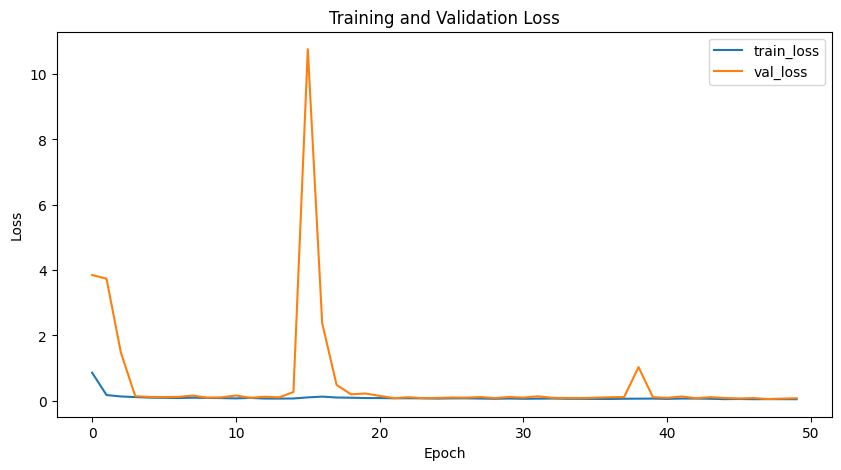

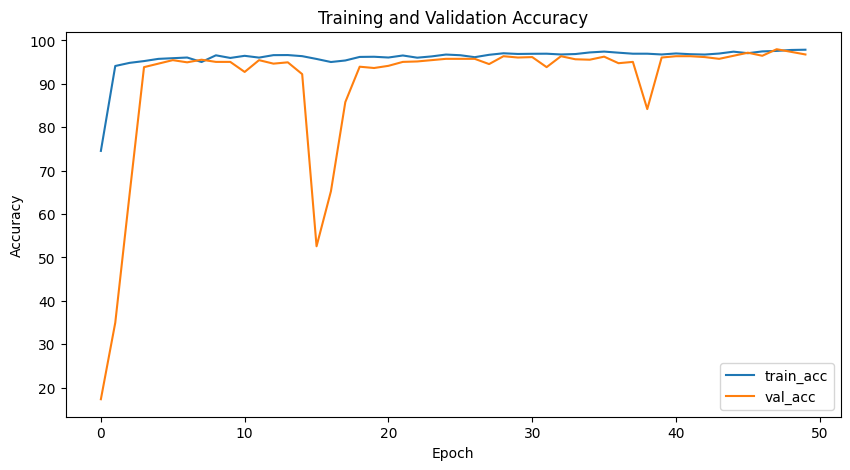

In [18]:
import matplotlib.pyplot as plt


def plot_loss_and_acc(train_loss_list, train_acc_list, val_loss_list, val_acc_list):
    # 绘制训练和验证损失
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_list, label='train_loss')
    plt.plot(val_loss_list, label='val_loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # 绘制训练和验证准确率
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc_list, label='train_acc')
    plt.plot(val_acc_list, label='val_acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
plot_loss_and_acc(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

In [19]:
from sklearn.metrics import classification_report
def test_final(model, test_dataloader,loss_weight = 0.007):
    # 将模型设置为测试模式.
    model.eval()

       # 定义损失函数和优化器.
    criterion1 = nn.CrossEntropyLoss()
    #criterion2 = CenterLoss(6, 6).to(device)

    loss_weight=0.007
    # 在测试集上测试模型.
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            # 将输入和标签数据转换为Tensor并放到GPU上（如果有的话）.
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 前向传播.
            outputs = model(inputs)
            pre_lab = torch.argmax(outputs, 1)
            # 计算损失和准确率.
            #loss = criterion1(outputs, labels)
            loss = criterion1(outputs, labels)# + loss_weight * criterion2(labels, outputs)
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            # 累计测试损失.
            test_loss += loss.item()
            y_true.extend(labels.tolist())
            y_pred.extend(pre_lab.tolist())
    report = classification_report(y_true, y_pred, digits=4)
    # 计算测试准确率和损失.
    test_acc = 100.0 * test_correct / test_total
    test_loss = test_loss / len(test_dataloader)

    # 打印测试结果.
    print('Test Loss: {:.4f}, Test Acc: {:.2f}%'.format(test_loss, test_acc))
    print(report)
    # 返回测试结果.
    return test_loss, test_acc

In [20]:
test_loss, test_acc=test_final(model, test_dataloader,loss_weight = 0.007)

Test Loss: 0.1167, Test Acc: 95.52%
              precision    recall  f1-score   support

           0     1.0000    0.9917    0.9959       121
           1     1.0000    1.0000    1.0000       120
           2     1.0000    1.0000    1.0000        95
           3     0.8450    0.8934    0.8685       122
           4     0.8889    0.8455    0.8667       123
           5     1.0000    1.0000    1.0000       155

    accuracy                         0.9552       736
   macro avg     0.9556    0.9551    0.9552       736
weighted avg     0.9557    0.9552    0.9552       736



开始绘制混淆矩阵


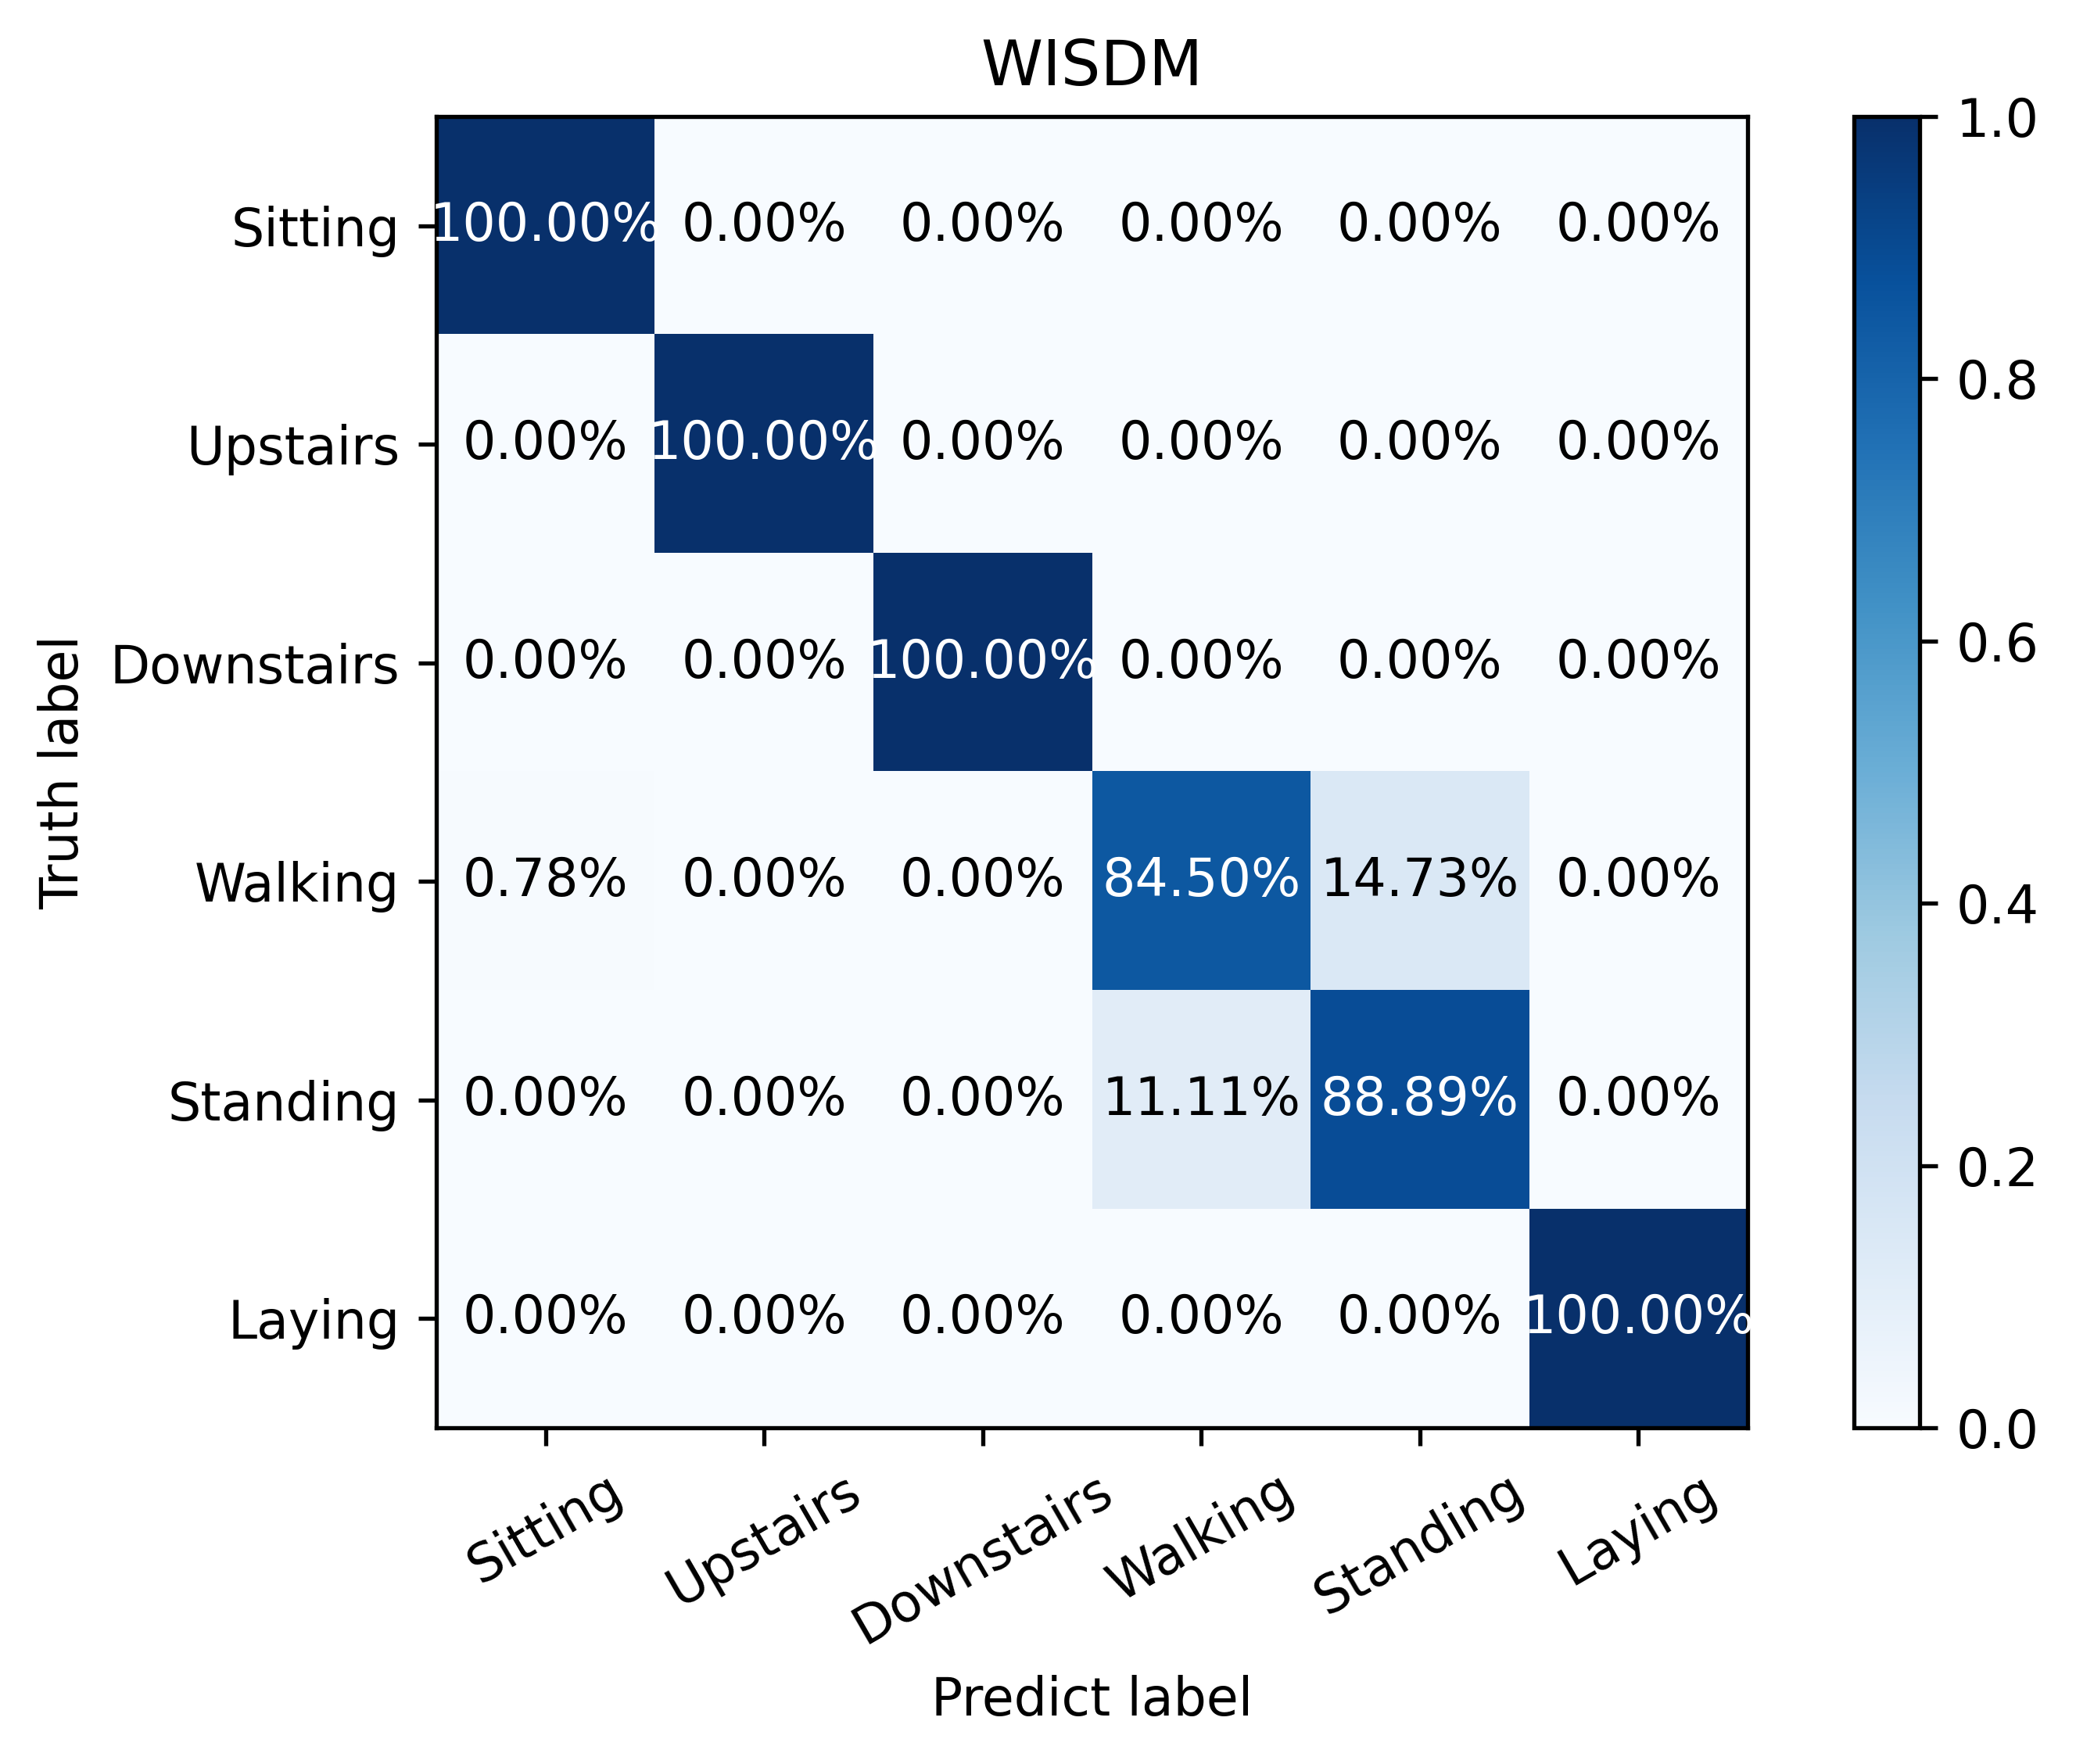

[[1.     0.     0.     0.     0.     0.    ]
 [0.     1.     0.     0.     0.     0.    ]
 [0.     0.     1.     0.     0.     0.    ]
 [0.0078 0.     0.     0.8449 0.1473 0.    ]
 [0.     0.     0.     0.1111 0.8889 0.    ]
 [0.     0.     0.     0.     0.     1.    ]]


In [21]:
from sklearn.manifold import TSNE
class DrawConfusionMatrix:
    def __init__(self, labels_name, normalize=True):
        self.normalize = normalize
        self.labels_name = labels_name
        self.num_classes = len(labels_name)
        self.matrix = np.zeros((self.num_classes, self.num_classes), dtype="float32")

    def update(self, labels, predicts):

        for predict, label in zip(labels, predicts):
            self.matrix[label, predict] += 1

    def getMatrix(self,normalize=True):
        if normalize:
            per_sum = self.matrix.sum(axis=1)  # 计算每行的和，用于百分比计算
            for i in range(self.num_classes):
                self.matrix[i] =(self.matrix[i] / per_sum[i])   # 百分比转换
            self.matrix=np.around(self.matrix, 4)   # 保留2位小数点
            self.matrix[np.isnan(self.matrix)] = 0.0  # 可能存在NaN，将其设为0
        return self.matrix

    def drawMatrix(self):
        self.matrix = self.getMatrix(self.normalize)
        plt.figure(dpi=480)
        plt.imshow(self.matrix, cmap=plt.cm.Blues)  # 仅画出颜色格子，没有值
        plt.title("WISDM")  # title
        plt.xlabel("Predict label")
        plt.ylabel("Truth label")

        plt.yticks(range(self.num_classes), self.labels_name)  # y轴标签
        plt.xticks(range(self.num_classes), self.labels_name, rotation=30)  # x轴标签
        thresh = self.matrix.max() / 2.
        for x in range(self.num_classes):
            for y in range(self.num_classes):
                #value = float(format('%.4f' % self.matrix[y, x]))*100.00 # 数值处理
                value = str(format('%.2f' %float(self.matrix[y, x]*100.00)))+'%' # 数值处理
                plt.text(x, y, value, verticalalignment='center', horizontalalignment='center',color="white" if self.matrix[y, x] > thresh else "black")  # 写值

        plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域

        plt.colorbar()  # 色条
        plt.savefig('./ConfusionMatrix.png', bbox_inches='tight')  # bbox_inches='tight'可确保标签信息显示全
        plt.show()

        
def printMatrix(test_loader, model):
    labels_name=["Sitting", "Upstairs", "Downstairs","Walking", "Standing", "Laying"]
    #labels_name=["Walking", "Walk upstairs", "Walk downstairs", "Sitting", "Standing", "Laying down"]

    drawconfusionmatrix = DrawConfusionMatrix(labels_name=labels_name)  # 实例化
    for index, (imgs,labels ) in enumerate(test_loader,1):
        labels_pd= model(imgs.float())
        predict_np = np.argmax(labels_pd.cpu().detach().numpy(), axis=-1)   # array([0,5,1,6,3,...],dtype=int64)
        labels_np = labels.numpy()                                    # array([0,5,0,6,2,...],dtype=int64)
        drawconfusionmatrix.update(labels_np, predict_np)   # 将新批次的predict和label更新（保存）

    drawconfusionmatrix.drawMatrix()  # 根据所有predict和label，画出混淆矩阵

    confusion_mat=drawconfusionmatrix.getMatrix() # 你也可以使用该函数获取混淆矩阵(ndarray)
    print(confusion_mat)
print("开始绘制混淆矩阵")
printMatrix(test_dataloader, model)